## Monitoring-health-using-Fitness-band-data-beats-per-minute-
## Part 1: Pulse Rate Determination

### Contents



### Dataset
We used the **Troika**[1] dataset to build your algorithm. Dataset folder is under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [ ]:
# Clone the entire repo.
!git clone -l -s git://github.com/ApoorvaKrisna/Monitoring-health-using-Fitness-band-data-beats-per-minute- cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1632
Receiving objects: 100% (1638/1638), 346.16 MiB | 29.67 MiB/s, done.
Resolving deltas: 100% (781/781), done.
Checking out files: 100% (1542/1542), done.
/content/cloned-repo
Datasets


In [ ]:
!pip install unrar

In [ ]:
cd /content/cloned-repo/Datasets/part_1/datasets/

/content/cloned-repo/Datasets/part_1/datasets


In [ ]:
!unrar x "/content/cloned-repo/Datasets/part_1/datasets/troika.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/cloned-repo/Datasets/part_1/datasets/troika.rar

Creating    troika                                                    OK
Creating    troika/training_data                                      OK
Extracting  troika/training_data/DATA_01_TYPE01.mat                        8%  OK 
Extracting  troika/training_data/DATA_02_TYPE02.mat                       17%  OK 
Extracting  troika/training_data/DATA_03_TYPE02.mat                       25%  OK 
Extracting  troika/training_data/DATA_04_TYPE01.mat                       30%  OK 
Extracting  troika/training_data/DATA_04_TYPE02.mat                       38%  OK 
Extracting  troika/training_data/DATA_05_TYPE02.mat                       46%  OK 
Extracting  troika/training_data/DATA_06_TYPE02.mat                       55%  OK 
Extracting  troika/training_data/DATA_07_TYPE02.mat                

In [ ]:
cd /content/cloned-repo/Datasets/part_1

/content/cloned-repo/Datasets/part_1


In [ ]:
import numpy as np
import glob
import warnings
import scipy as sp
import scipy.io
import scipy.signal
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")

% matplotlib inline
plt.style.use('ggplot')


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


In [ ]:
data_fls, ref_fls = LoadTroikaDataset()

In [ ]:
data_fls

['./datasets/troika/training_data/DATA_01_TYPE01.mat',
 './datasets/troika/training_data/DATA_02_TYPE02.mat',
 './datasets/troika/training_data/DATA_03_TYPE02.mat',
 './datasets/troika/training_data/DATA_04_TYPE01.mat',
 './datasets/troika/training_data/DATA_04_TYPE02.mat',
 './datasets/troika/training_data/DATA_05_TYPE02.mat',
 './datasets/troika/training_data/DATA_06_TYPE02.mat',
 './datasets/troika/training_data/DATA_07_TYPE02.mat',
 './datasets/troika/training_data/DATA_08_TYPE02.mat',
 './datasets/troika/training_data/DATA_10_TYPE02.mat',
 './datasets/troika/training_data/DATA_11_TYPE02.mat',
 './datasets/troika/training_data/DATA_12_TYPE02.mat']

In [ ]:
ref_fls

['./datasets/troika/training_data/REF_01_TYPE01.mat',
 './datasets/troika/training_data/REF_02_TYPE02.mat',
 './datasets/troika/training_data/REF_03_TYPE02.mat',
 './datasets/troika/training_data/REF_04_TYPE01.mat',
 './datasets/troika/training_data/REF_04_TYPE02.mat',
 './datasets/troika/training_data/REF_05_TYPE02.mat',
 './datasets/troika/training_data/REF_06_TYPE02.mat',
 './datasets/troika/training_data/REF_07_TYPE02.mat',
 './datasets/troika/training_data/REF_08_TYPE02.mat',
 './datasets/troika/training_data/REF_10_TYPE02.mat',
 './datasets/troika/training_data/REF_11_TYPE02.mat',
 './datasets/troika/training_data/REF_12_TYPE02.mat']

# Spectrogram
A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.

#Bandpass Filter
In a receiver, a bandpass filter allows signals within a selected range of frequencies to be heard or decoded, while preventing signals at unwanted frequencies from getting through. Signals at frequencies outside the band which the receiver is tuned at, can either saturate or damage the receiver.

In [ ]:
def BandpassFilter(sig, freq_filter=(40 / 60, 240 / 60), fs=125):
    """Bandpass Filter.

    Args:
        signal: (np.array) The input signal
        pass_band: (tuple) The pass band
        Frequency components outside two elements in the tuple will be removed
        fs: (number) The sampling rate of <signal>

    Returns:
        (np.array) The filtered signal
    """
    b, a = scipy.signal.butter(3, freq_filter, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, sig)


def PlotSpectrogram(sig, fs):
    """
    Plots Spectogram
    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>

    Returns:
        Plot
    """
    fig = plt.figure(figsize=(8, 5))
    plt.specgram(sig, Fs=fs, NFFT=250,
                 noverlap=125, xextent=[0, len(sig) / fs / 60]);
    plt.xlabel('Time (min)')
    plt.ylabel('Frequency (Hz)')


def PlotFilteredSpectogram(sig):
    """
    Plots Spectogram
    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>

    Returns:
        Plot

    """
    fig = plt.figure(figsize=(8, 5))
    filtered_sig = BandpassFilter(sig)
    plt.specgram(filtered_sig, Fs=fs, NFFT=250,
                 noverlap=125, xextent=[0, len(sig) / fs / 60]);
    plt.xlabel('Time (min)')
    plt.ylabel('Frequency (Hz)')


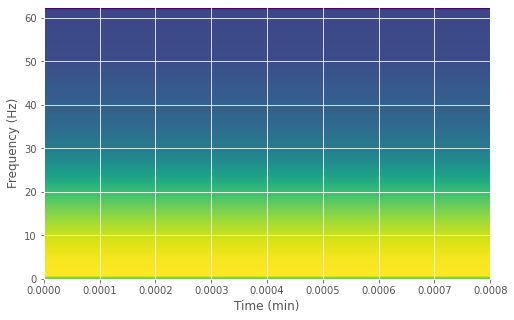

In [ ]:
fs = 125
freq_filter=(40/60.0, 240/60.0)

PlotSpectrogram(sp.io.loadmat(data_fls[0])['sig'], fs)
    

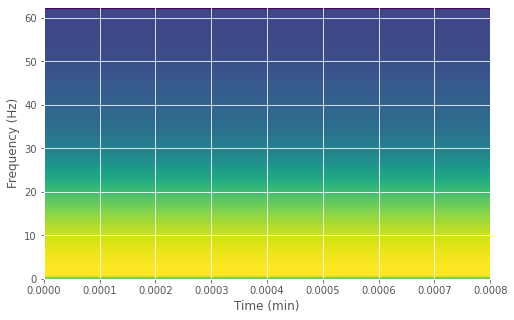

In [ ]:
PlotFilteredSpectogram(sp.io.loadmat(data_fls[0])['sig'])

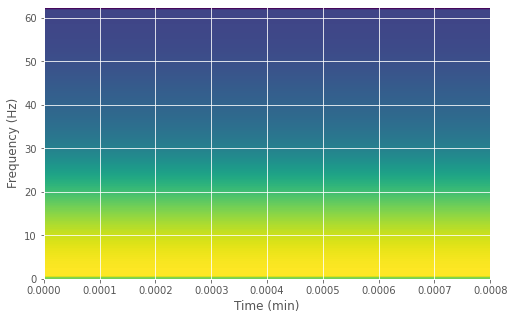

In [ ]:
PlotSpectrogram(sp.io.loadmat(data_fls[6])['sig'], fs)

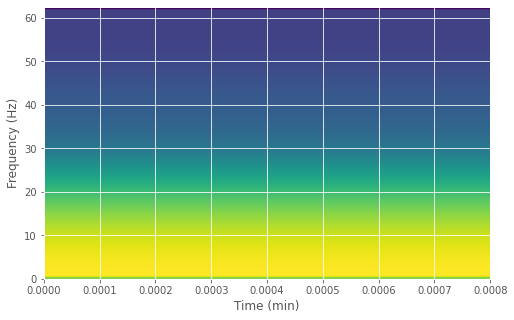

In [ ]:
PlotFilteredSpectogram(sp.io.loadmat(data_fls[6])['sig'])

In [ ]:
data_fl, ref_fl = data_fls[0], ref_fls[0]
bpm = sp.io.loadmat(ref_fl)['BPM0']
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
ppg = BandpassFilter(ppg)
accx = BandpassFilter(accx)
accy = BandpassFilter(accy)
accz = BandpassFilter(accz)
acc = np.sqrt(accx**2 + accy**2 + accz**2)
acc

array([0.02203684, 0.02803522, 0.03435165, ..., 0.01121658, 0.0104505 ,
       0.00960517])

# **The Fourier transform is used to analyze problems involving continuous-time signals or mixtures of continuous- and discrete-time signals. The discrete-time Fourier transform is used to analyze problems involving discrete-time signals or systems.**

In [ ]:
def FourierTransform(signal, fs):
    """
    Discrete Fourier Transform on a signal
    Args:
        signal: (np.array) The input signal
        fs: (number) The sampling rate of <signal>

    Returns:
        Freq and Magnitude of the signal
    """
    freqs = np.fft.rfftfreq(6 * len(signal), 1 / fs)
    fft = np.abs(np.fft.rfft(signal, 6 * len(signal)))
    return freqs, fft


def Plotfft(signal, freqs, fft, fs):
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(2, 1, 1)
    ts = np.arange(len(signal)) / fs
    plt.plot(ts, signal)
    plt.subplot(2, 1, 2)
    plt.plot(freqs, np.abs(fft))
    plt.title("freq domain")
    plt.xlabel("freq")
    plt.tight_layout()


In [ ]:
ppg_window = ppg[0:8*fs]
acc_window = acc[0:8*fs]
ppg_freqs, ppg_fft = FourierTransform(ppg_window, fs)

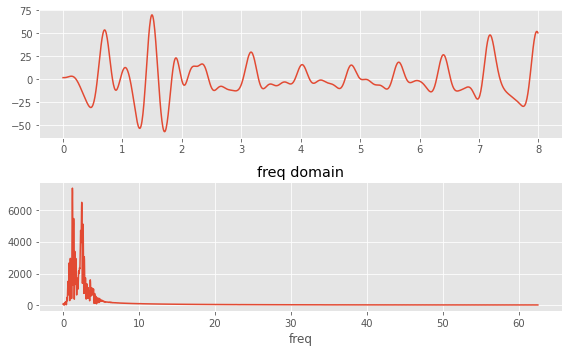

In [ ]:
Plotfft(ppg_window, ppg_freqs, ppg_fft, fs)

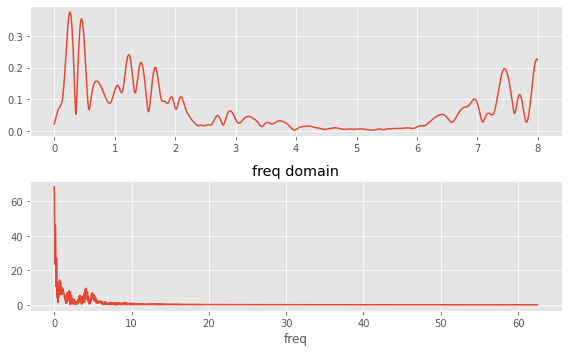

In [ ]:
acc_freqs, acc_fft = FourierTransform(acc_window, fs)
Plotfft(acc_window, acc_freqs, acc_fft, fs)


#### Find Peaks

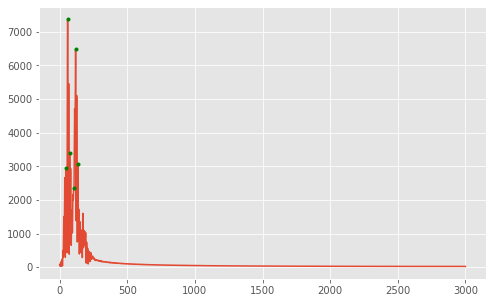

In [ ]:
peaks_ppg = sp.signal.find_peaks(ppg_fft, height=2000, distance=10)[0]
fig= plt.figure(figsize=(8,5))
plt.plot(ppg_fft)
plt.plot(peaks_ppg, ppg_fft[peaks_ppg], 'g.');

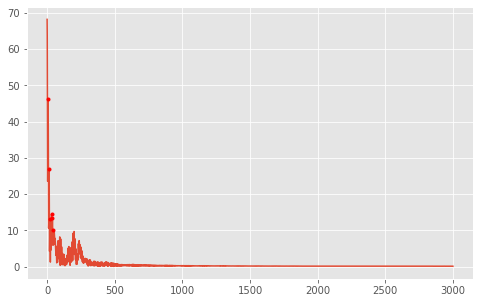

In [ ]:
peaks_acc = sp.signal.find_peaks(acc_fft, height=10)[0]
fig= plt.figure(figsize=(8,5))
plt.plot(acc_fft)
plt.plot(peaks_acc, acc_fft[peaks_acc], 'r.');

In [ ]:
accx_window = accx[0:8*fs]
accy_window = accy[0:8*fs]
accz_window = accz[0:8*fs]

In [ ]:
accx_freqs, accx_fft = FourierTransform(accx_window, fs)
accy_freqs, accy_fft = FourierTransform(accy_window, fs)
accz_freqs, accz_fft = FourierTransform(accz_window, fs)

[0.66666667 0.83333333 0.97916667 1.125     ]
[0.77083333 1.79166667 1.9375     2.10416667]
[0.66666667 0.8125     0.97916667 1.25       1.39583333 1.54166667
 1.66666667 1.8125     2.20833333 2.35416667 2.47916667 2.625
 2.77083333]


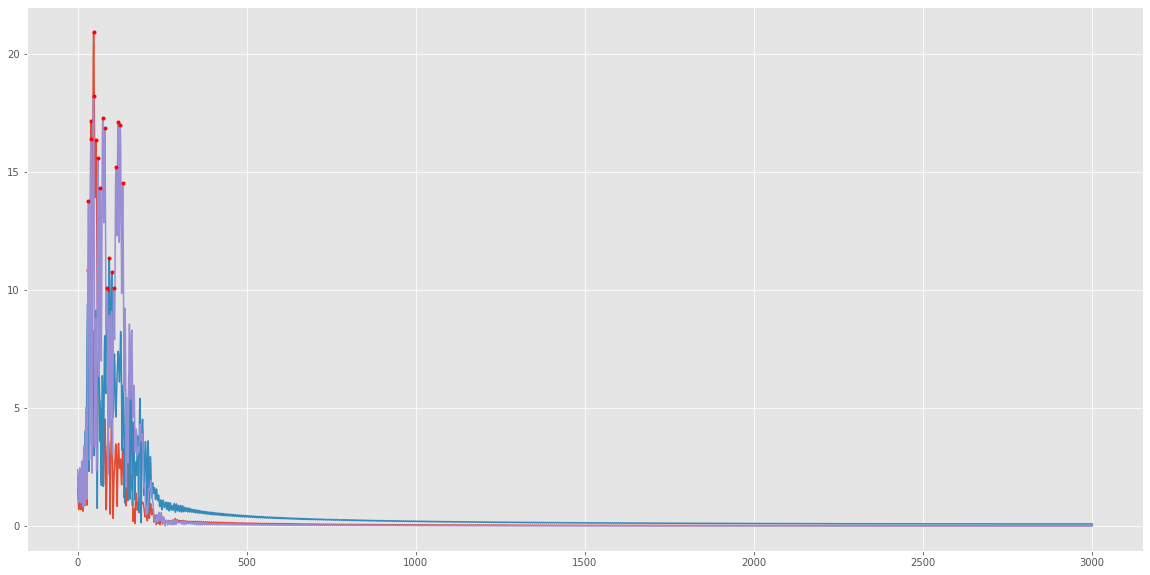

In [ ]:
peaks_accx = sp.signal.find_peaks(accx_fft, height=10)[0]
fig= plt.figure(figsize=(20,10))
plt.plot(accx_fft)
plt.plot(peaks_accx, accx_fft[peaks_accx], 'r.')
print(accx_freqs[peaks_accx])

peaks_accy = sp.signal.find_peaks(accy_fft, height=10)[0]
plt.plot(accy_fft)
plt.plot(peaks_accy, accy_fft[peaks_accy], 'r.')
print(accy_freqs[peaks_accy])

peaks_accz = sp.signal.find_peaks(accz_fft, height=10)[0]
plt.plot(accz_fft)
plt.plot(peaks_accz, accz_fft[peaks_accz], 'r.')
print(accz_freqs[peaks_accz])

### Metrics

In [ ]:
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


In [ ]:
def CreateFeatures(ppg, accx, accy, accz, fs=125):
    """
    Create features from the data

    Args:
        ppg: (np.array) The input signal
        accx
        accy
        accz
        fs: (number) The sampling rate of <signal>

    Returns:
        PPG and ACC features
    """

    # Filter data
    ppg_freqs, ppg_fft = FourierTransform(ppg, fs)
    ppg_fft[ppg_freqs <= 40 / 60] = 0.0
    ppg_fft[ppg_freqs >= 240 / 60] = 0.0

    acc = np.sqrt(accx ** 2 + accy ** 2 + accz ** 2)

    # FFT for acc
    acc_freqs, acc_fft = FourierTransform(acc, fs)
    acc_fft[acc_freqs <= 40 / 60] = 0.0
    acc_fft[acc_freqs >= 240 / 60] = 0.0

    # max freq for ppg
    ppg_feature = ppg_freqs[np.argmax(ppg_fft)]

    # max freq for acc
    acc_feature = acc_freqs[np.argmax(acc_fft)]

    # The mean of each channel
    mn_x = np.mean(accx)
    mn_y = np.mean(accy)
    mn_z = np.mean(accz)

    # The standard deviation of each channel
    std_x = np.std(accx)
    std_y = np.std(accy)
    std_z = np.std(accz)

    # Various percentile values for each channel
    p5_x = np.percentile(accx, 5)
    p5_y = np.percentile(accy, 5)
    p5_z = np.percentile(accz, 5)
    p10_x = np.percentile(accx, 10)
    p10_y = np.percentile(accy, 10)
    p10_z = np.percentile(accz, 10)
    p25_x = np.percentile(accx, 25)
    p25_y = np.percentile(accy, 25)
    p25_z = np.percentile(accz, 25)
    p50_x = np.percentile(accx, 50)
    p50_y = np.percentile(accy, 50)
    p50_z = np.percentile(accz, 50)
    p90_x = np.percentile(accx, 90)
    p90_y = np.percentile(accy, 90)
    p90_z = np.percentile(accz, 90)
    return np.array([ppg_feature, acc_feature, mn_x, mn_y,
                     mn_z, std_x, std_y, std_z, p5_x, p5_y, p5_z, p10_x, p10_y, p10_z
                        , p25_x, p25_y, p25_z, p50_x, p50_y, p50_z, p90_x, p90_y, p90_z])


In [ ]:
CreateFeatures(ppg, accx, accy, accz, fs = 125)

array([ 2.92041191e+00,  2.91931360e+00,  2.97795087e-05,  1.56882313e-05,
       -4.37662684e-05,  4.94873121e-01,  5.85681315e-01,  6.38801543e-01,
       -1.01132598e+00, -1.03581436e+00, -1.28762826e+00, -7.36608861e-01,
       -7.93157948e-01, -9.30701120e-01, -1.82453756e-01, -3.05749117e-01,
       -2.69127674e-01,  1.73263823e-02,  2.07283652e-03,  1.44392591e-02,
        5.66618496e-01,  7.94206644e-01,  8.04267509e-01])

#Random Forest Regression
Random forest is an ensemble of decision trees. This is to say that many trees, constructed in a certain “random” way form a Random Forest. 


*   Each tree is created from a different sample of rows and at each node, a different sample of features is selected for splitting.
*   Each of the trees makes its own individual prediction.
*   These predictions are then averaged to produce a single result. 

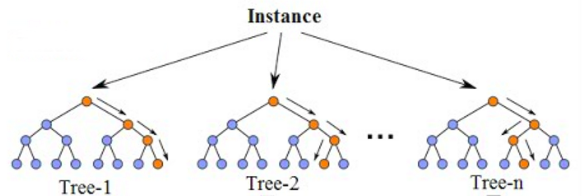


 
 




In [ ]:
def RandomForestRegressorModel():
    """
    Train Regressor model

    Returns:
        Trained model
    """
    fs = 125
    win_length = 8
    win_shift = 2

    # Load filenames through LoadTroikaDataset
    data_fls, ref_fls = LoadTroikaDataset()
    features, labels, signals = [], [], []

    for data_fl, ref_fl in zip(data_fls, ref_fls):
        signal = LoadTroikaDataFile(data_fl)
        ref = np.array([_[0] for _ in scipy.io.loadmat(ref_fl)['BPM0']])
        left_s = (np.cumsum(np.ones(min(signal.shape[1],
                                        len(ref))) * fs * win_shift) -
                  fs * win_shift).astype(int)
        right_s = left_s + fs * win_length
        for i in range(len(left_s)):
            left, right = left_s[i], right_s[i]
            ppg = BandpassFilter(signal[0, left:right])
            accx = BandpassFilter(signal[1, left:right])
            accy = BandpassFilter(signal[2, left:right])
            accz = BandpassFilter(signal[3, left:right])

            features.append(CreateFeatures(ppg, accx, accy, accz))
            labels.append(ref[i])
            signals.append([ppg, accx, accy, accz])

    features, labels = np.array(features), np.array(labels)
    model = RandomForestRegressor(n_estimators=50,
                                  max_depth=10, random_state=42,
                                  criterion='mae',
                                  min_samples_split=5)
    for train_idx, test_idx in KFold(n_splits=5).split(features, labels):
        X_train, y_train = features[train_idx], labels[train_idx]
        X_test, y_test = features[test_idx], labels[test_idx]
        model.fit(X_train, y_train)

    return model


In [ ]:
def ProcessData(data_fl, ref_fl):
    """
    Process Data
    Args:
        data_fl: data files
        ref_fls: refrence files
    Returns:
        features, labels, signals
    """
    # Load data using LoadTroikaDataFile
    signal = LoadTroikaDataFile(data_fl)
    features, labels, signals = [], [], []
    # Load ground truth heart rate
    ref = np.array([_[0] for _ in scipy.io.loadmat(ref_fl)['BPM0']])
    fs = 125
    win_length = 8
    win_shift = 2
    left_s = (np.cumsum(np.ones(min(signal.shape[1],
                                    len(ref))) * fs * win_shift) -
              fs * win_shift).astype(int)
    right_s = left_s + fs * win_length
    for i in range(len(left_s)):
        left, right = left_s[i], right_s[i]
        ppg = BandpassFilter(signal[0, left:right])
        accx = BandpassFilter(signal[1, left:right])
        accy = BandpassFilter(signal[2, left:right])
        accz = BandpassFilter(signal[3, left:right])
        features.append(CreateFeatures(ppg, accx, accy, accz))
        labels.append(ref[i])
        signals.append([ppg, accx, accy, accz])
    return features, labels, signals


In [ ]:
def RunPulseRateAlgorithm(data_fl, ref_fl):
    """
    Process Data
    Args:
        data_fl: data files
        ref_fls: refrence files
    Returns:
        errors, confidence
    """
    features, labels, signals = ProcessData(data_fl, ref_fl)
    features, labels = np.array(features), np.array(labels)
    model = RandomForestRegressorModel()
    k = 10

    # Compute pulse rate estimates and estimation confidence.
    errors, confidence = [], []

    for i in range(len(signals)):
        feature, label = features[i], labels[i]
        ppg, accx, accy, accz = signals[i]
        pred = model.predict(np.reshape(feature, (1, -1)))[0]
        if k>0:
          print(pred, label)
          k--
        ppg = BandpassFilter(ppg)
        accx = BandpassFilter(accx)
        accy = BandpassFilter(accy)
        accz = BandpassFilter(accz)

        freqs = np.fft.rfftfreq(2 * len(ppg), 1 / fs)
        fft = np.abs(np.fft.rfft(ppg, 2 * len(ppg)))
        fft[freqs <= 40 / 60] = 0.0
        fft[freqs >= 240 / 60] = 0.0

        pred_fs = pred / 55
        pred_fs_win = (freqs >= pred_fs - 0.5) & (freqs <= pred_fs + 0.5)
        confid = np.sum(fft[pred_fs_win]) / np.sum(fft)

        errors.append(np.abs(pred - label))
        confidence.append(confid)

    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence


# **We are calculating heartbeat using fitness band data (PPG, ECG, acceleration signals) and comparing it with the actual heartbeat values to calculate the error metric.**

In [ ]:
Evaluate()

75.95469387908966 74.33920704845815
77.53442617317977 76.35746606334841
76.69576109219612 77.14285714285714
75.10512151273132 74.66814159292035
73.72339997903 72.58064516129032
72.08523624154584 71.68458781362007
74.54721143534987 72.89416846652267
74.9405953522616 73.449401523395
77.26787309317758 75.33482142857142
77.61577532610654 76.84426229508196
77.90168393466321 79.59905660377359
80.60575334244191 79.11392405063292
75.63517499056165 74.50331125827813
71.31693582001891 70.83825265643448
70.70894116892865 69.58762886597938
71.00161729158435 71.94244604316548
79.03277877812673 77.31958762886597
79.97960431398744 80.29978586723769
85.90062636227879 82.87292817679558
90.41725013564465 83.51893095768374
104.87034957746877 84.65011286681715
122.30240522613444 88.23529411764706
105.51796509883887 90.95920617420066
106.97538150952276 92.87925696594428
107.43412732949142 94.73684210526316
113.36595097594076 97.2877358490566
112.96242306653362 99.66777408637873
111.66120892558034 101.58013

5.8296718811340185